<a href="https://colab.research.google.com/github/AfefThabet/Reconnaissance-d-empreintes-digitales-endommagees/blob/main/Fing_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

# Load Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dnyaneshwalwadkar/fingerprintdata-npz")

print("Path to dataset files:", path)

In [ ]:
x_real = np.load(path+'/dataset/x_real.npz')['data']
y_real = np.load(path+'/dataset/y_real.npy')
x_easy = np.load(path+'/dataset/x_easy.npz')['data']
y_easy = np.load(path+'/dataset/y_easy.npy')
x_medium = np.load(path+'/dataset/x_medium.npz')['data']
y_medium = np.load(path+'/dataset/y_medium.npy')
x_hard = np.load(path+'/dataset/x_hard.npz')['data']
y_hard = np.load(path+'/dataset/y_hard.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

# Train Test Split

In [ ]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data_ = np.concatenate([y_easy, y_medium, y_hard], axis=0)

print(label_data_[:,0])#subject_id(1-600)

unique_values = np.unique(label_data_[:, 0])
print(unique_values)

label_data= label_data_[:,0] -1
print(np.unique(label_data))#subject_id(0-599)

x_train, x_temp, label_train, label_temp = train_test_split(x_data, label_data, test_size=0.2,shuffle=True,random_state=41)
x_val, x_test, label_val, label_test = train_test_split(x_temp, label_temp, test_size=0.5,shuffle=True,random_state=41)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)
print(x_test.shape, label_test.shape)


# Data Generator

In [ ]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights
import torchvision.transforms.functional as F

# load the VGG16 network *pre-trained* on the ImageNet dataset
weights = VGG16_Weights.DEFAULT

In [ ]:
pre_trans = weights.transforms()
pre_trans

This is eqiuvalent to the following:
```
IMG_WIDTH, IMG_HEIGHT = (224, 224)
pre_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0, 1]
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    transforms.CenterCrop(224)
])
```

In [ ]:
class MyDataset(Dataset):
    def __init__(self, x_data, label_data):
        self.x_data = x_data  # Expect shape (N, 90, 90, 1)
        self.label_data = label_data

    def __getitem__(self, idx):
        image = F.to_pil_image(self.x_data[idx].squeeze())
        image = image.convert('RGB')
        image = pre_trans(image).to(device)
        label = torch.tensor(self.label_data[idx], dtype=torch.long).to(device)
        return image, label

    def __len__(self):
        return len(self.x_data)

In [ ]:
# Create instances of MyDataset for training and validation
train_data = MyDataset(x_train, label_train)
val_data = MyDataset(x_val, label_val)
test_data = MyDataset(x_test, label_test)
# Create DataLoader for training data
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
train_N = len(train_loader.dataset)
valid_N = len(val_loader.dataset)
test_N = len(test_loader.dataset)
# Example usage
for batch_x, batch_y in train_loader:
    print(batch_x.shape, batch_y.shape)  # Print shapes of a batch
    break

# Create Model

In [ ]:
vgg = vgg16(pretrained=True)
N_CLASSES = 600
for param in vgg.features.parameters():
  param.requires_grad=False
for param in vgg.features[24:].parameters():
  param.requires_grad=True
vgg.avgpool = nn.AdaptiveAvgPool2d((1, 1))
vgg.classifier = nn.Sequential(
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)
vgg.to(device)

In [ ]:
from torchsummary import summary
summary(vgg, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N
def train(model, train_loader, train_N, optimizer, loss_function):
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

def validate(model, valid_loader, valid_N, loss_function):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [ ]:
from torch.optim import Adam
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.0001)
#optimizer = torch.optim.Adam([
#    {'params': vgg.features.parameters(), 'lr': 1e-5},
#    {'params': vgg.classifier.parameters(), 'lr': 1e-4}
#])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

def get_batch_predictions(output):
    return output.argmax(dim=1)

def train(model, train_loader, train_N, optimizer, loss_function, metrics_history):
    total_loss = 0
    total_correct = 0
    all_preds = []
    all_targets = []

    model.train()
    for x, y in train_loader:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()
        total_correct += (get_batch_predictions(output) == y).sum().item()

        all_preds.extend(get_batch_predictions(output).cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / train_N
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    metrics_history['train_loss'].append(avg_loss)
    metrics_history['train_accuracy'].append(accuracy)
    metrics_history['train_precision'].append(precision)
    metrics_history['train_recall'].append(recall)
    metrics_history['train_f1'].append(f1)

    print('Train - Loss: {:.4f} Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1-Score: {:.4f}'.format(
        avg_loss, accuracy, precision, recall, f1))


def validate(model, valid_loader, valid_N, loss_function, metrics_history):
    total_loss = 0
    total_correct = 0
    all_preds = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)
            total_loss += loss_function(output, y).item()
            total_correct += (get_batch_predictions(output) == y).sum().item()

            all_preds.extend(get_batch_predictions(output).cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(valid_loader)
    accuracy = total_correct / valid_N
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    metrics_history['valid_loss'].append(avg_loss)
    metrics_history['valid_accuracy'].append(accuracy)
    metrics_history['valid_precision'].append(precision)
    metrics_history['valid_recall'].append(recall)
    metrics_history['valid_f1'].append(f1)

    print('Valid - Loss: {:.4f} Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1-Score: {:.4f}'.format(
        avg_loss, accuracy, precision, recall, f1))


In [ ]:
def plot_metrics(metrics_history):
    epochs = range(1, len(metrics_history['train_accuracy']) + 1)

    #Plot Loss
    plt.figure(figsize=(10, 9))
    plt.subplot(3, 2, 1)
    plt.plot(epochs, metrics_history['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics_history['valid_loss'], label='Valid Loss')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')
    # Plot Recall
    plt.subplot(3, 2, 2)
    plt.plot(epochs, metrics_history['train_recall'], label='Train Recall')
    plt.plot(epochs, metrics_history['valid_recall'], label='Valid Recall')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Recall vs Epochs')

    # Plot Accuracy
    plt.subplot(3, 2, 3)
    plt.plot(epochs, metrics_history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics_history['valid_accuracy'], label='Valid Accuracy')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')

    # Plot Precision
    plt.subplot(3, 2, 4)
    plt.plot(epochs, metrics_history['train_precision'], label='Train Precision')
    plt.plot(epochs, metrics_history['valid_precision'], label='Valid Precision')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision vs Epochs')

    # Plot F1-Score
    plt.subplot(3, 2, 5)
    plt.plot(epochs, metrics_history['train_f1'], label='Train F1-Score')
    plt.plot(epochs, metrics_history['valid_f1'], label='Valid F1-Score')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.title('F1-Score vs Epochs')

    plt.tight_layout()
    plt.show()

In [ ]:
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],
    'valid_loss': [],
    'valid_accuracy': [],
    'valid_precision': [],
    'valid_recall': [],
    'valid_f1': [],
}

# Train and Evaluation

In [ ]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(vgg, train_loader, train_N, optimizer, loss_function,metrics_history)
    validate(vgg, val_loader, valid_N, loss_function,metrics_history)

Epoch: 0
Train - Loss: 4.7790 Accuracy: 0.0964 Precision: 0.1087 Recall: 0.0964 F1-Score: 0.0917
Valid - Loss: 3.3237 Accuracy: 0.2488 Precision: 0.2944 Recall: 0.2488 F1-Score: 0.2191
Epoch: 1
Train - Loss: 2.2178 Accuracy: 0.4542 Precision: 0.4486 Recall: 0.4542 F1-Score: 0.4465
Valid - Loss: 1.5104 Accuracy: 0.6075 Precision: 0.6955 Recall: 0.6075 F1-Score: 0.6009
Epoch: 2
Train - Loss: 0.8330 Accuracy: 0.7695 Precision: 0.7697 Recall: 0.7695 F1-Score: 0.7685
Valid - Loss: 0.6016 Accuracy: 0.8287 Precision: 0.8745 Recall: 0.8287 F1-Score: 0.8288
Epoch: 3
Train - Loss: 0.3235 Accuracy: 0.9082 Precision: 0.9086 Recall: 0.9082 F1-Score: 0.9081
Valid - Loss: 0.3660 Accuracy: 0.8914 Precision: 0.9169 Recall: 0.8914 F1-Score: 0.8897
Epoch: 4
Train - Loss: 0.1781 Accuracy: 0.9495 Precision: 0.9498 Recall: 0.9495 F1-Score: 0.9495
Valid - Loss: 0.2802 Accuracy: 0.9172 Precision: 0.9407 Recall: 0.9172 F1-Score: 0.9187
Epoch: 5
Train - Loss: 0.1393 Accuracy: 0.9601 Precision: 0.9603 Recall: 0.

In [ ]:
torch.save(vgg.state_dict(), 'Fing-VGG16_model.pth')
#vgg.load_state_dict(torch.load('vgg_model.pth'))

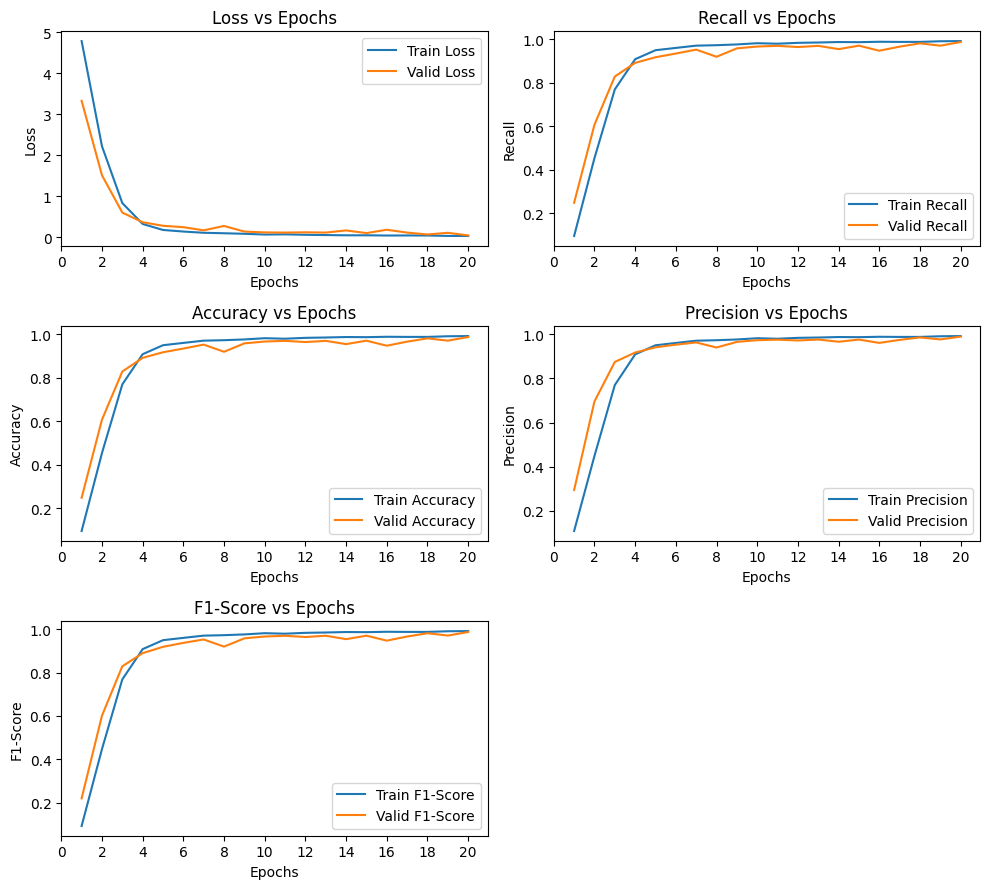

In [ ]:
plot_metrics(metrics_history)

In [ ]:
def test(model, test_loader, test_N):
    total_correct = 0
    all_preds = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            total_correct += (get_batch_predictions(output) == y).sum().item()

            all_preds.extend(get_batch_predictions(output).cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    accuracy = total_correct / test_N
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    print('Test - Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1-Score: {:.4f}'.format(accuracy, precision, recall, f1))

In [ ]:
test(vgg, test_loader, test_N)

Test - Accuracy: 0.9884 Precision: 0.9901 Recall: 0.9884 F1-Score: 0.9884
